# Обучение без учителя
Особенности:
* можно использовать больше данных, т.к. не нужна разметка
* нет очевидных метрик качества

Первая задача: снижение размерности данных (визуализация, подготовка к дальнейшей обработке)

## Метод главных компонент (PCA)
Интуиция:
* первый шаг: предполагаем, что наши данные -- эллипсоид, мы хотим изменить базис пространства так, чтобы он совпадал с его осями
* дальше: предполагаем, что в некоторых измерениях эллипсоид мало вытянут, то есть они не несут пользы -- перекладываем его в меньшее пространство
* будем последовательно жадно отбрасывать наименее "широкие" измерения (по дисперсии вдоль осей)

Матрицу ковариации для нашей выборки $\mathbf{X}$ можно представить в виде произведения $\mathbf{X}^{T} \mathbf{X}$. Из [отношения Релея](https://ru.wikipedia.org/wiki/Отношение_Рэлея) вытекает, что максимальная вариация нашего набора данных будет достигаться вдоль собственного вектора этой матрицы, соответствующего максимальному собственному значению. Таким образом главные компоненты, на которые мы бы хотели спроецировать наши данные, являются просто собственными векторами соответствующих топ-k штук собственных значений этой матрицы.

Дальнейшие шаги просты до безобразия — надо просто умножить нашу матрицу данных на эти компоненты и мы получим проекцию наших данных в ортогональном базисе этих компонент. Теперь если мы транспонируем нашу матрицу данных и матрицу векторов главных компонент, мы восстановим исходную выборку в том пространстве, из которого мы делали проекцию на компоненты. Если количество компонент было меньше размерности исходного пространства, мы потеряем часть информации при таком преобразовании.

Экспериментируем на датасете с цифрами

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets, decomposition

%matplotlib inline

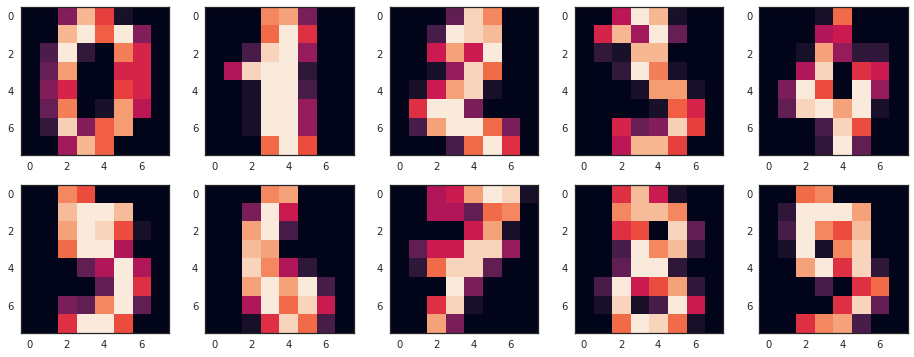

In [6]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]));

Projecting 64-dimensional data to 2D


Text(0.5,1,'MNIST. PCA projection')

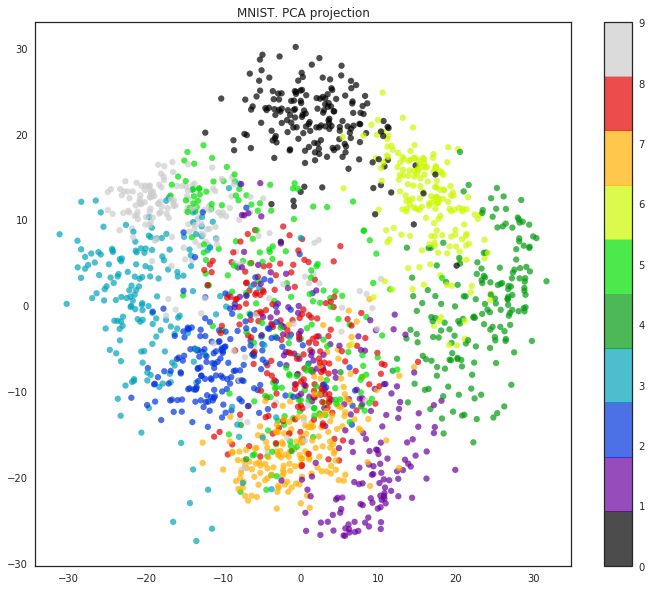

In [7]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection')

С t-SNE картинка получается еще лучше, поскольку **у PCA ограничение – он находит только линейные комбинации** исходных признаков. Зато даже на этом относительно небольшом наборе данных можно заметить, насколько t-SNE дольше работает.

### Параметры
На практике выбирают столько главных компонент, чтобы оставить 90% исходной дисперсии: в данном случае это 21 компонента из 64 исходных

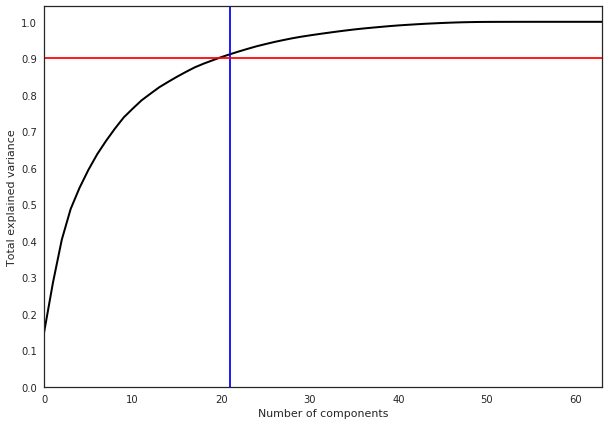

In [13]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b'); plt.axhline(0.9, c='r')
plt.show();

## Кластеризация

### k-means
* Итеративно выбираем центроиды, считаем кластеры, выбираем новые центроиды
* Для подсчета расстояний `from scipy.spatial.distance import cdist`
* Можно экспериментировать с критериями сходимости, метрики расстояния. Чувствителен к выбору центроидов -- запускаем много раз

Выбор $k$: метрика -- расстояние от всех точек до своих центров -- в какой-то момент начинает сходиться "не так быстро".

Сложности: 
* NP-полнота (есть эвристики, например, mini batch).

### Affinity Propagation
Насколько элементы одного кластера "похожи", могут быть "примером для подражания" элементов других кластеров.

### Спектральная кластеризация
TODO

### Агломеративная кластеризация
Последовательно склеиваем самые близкие (по центроидам / по ближайшим точкам / по наиболее удаленным точкам / в среднем) кластеры, пока все не склеим. Дальше по дереву склеивания или по "правилу локтя" как в k-means выбираем оптимальное место остановки.

### Метрики
* Adjusted Rand Index (ARI) -- мера расстояния между разными разбиениями выборки. Если есть правильные метки -- сравниваем с ними по ARI
* Adjusted Mutual Information (AMI) -- мера схожести разбиений по общей информации
* Гомогенность, полнота, V-мера -- насколько однородны кластера, насколько одинаково разложены элементы одинаковых кластеров, среднее гармоническое предшественников
* Силуэт -- если не знаем истинных меток, "силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров"